# Chinese Numbers MNIST

The <a href="https://www.kaggle.com/c/mnist-but-chinese/data" target ="_blank">dataset used</a> for this notebook was given as part of a <a href="https://www.kaggle.com/c/mnist-but-chinese/leaderboard" target ="_blank">Kaggle hackathon</a> by the **Consulting and Analytics Club, IIT Guwahati**  - of which I am a part. Originally collected by professors at the **Newcastle University**, it represents 10,000 training images and 5,000 test-set images. These are Chinese numerals, and are coded in the `.csv` files with the following convention:
    
    code ==> Number in image
    1. 1 ==> 0
    2. 2 ==> 1
    3. 3 ==> 2
    4. 4 ==> 3
    5. 5 ==> 4
    6. 6 ==> 5
    7. 7 ==> 6
    8. 8 ==> 7
    9. 9 ==> 8
    10. 10 ==> 9
    11. 11 ==> 10
    12. 12 ==> 100
    13. 13 ==> 1,000
    14. 14 ==> 10,000
    15. 15 ==> 100,000,000
    
The implementation in this notebook has been done in `PyTorch`, and uses a modified version of the `LeNet-5` CNN architecture (<a href = "http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf" target = "_blank">original paper from 1998</a>) that I've explained later in the notebook.

It takes "a while" to train on a CPU, which is why training on a GPU is advised. It is assumed the reader is aware of the associated syntax and may consider adding the relevant changes - if needed and wherever required. 

Alternatively, I could run this NB on the Colab kernel, but I haven't been able to figure out a reliable way to import all the required data while working there. Please do mention in the comments if you have a way to do that.

# Importing the relevant libraries

Some of the libraries I know that I'll be using right off the bat. A few might not even be required, but I'll keep them in the cell, because that gives an insight into my thought-process while making the model. Considering it'll increase the time taken to run the cell, not a very ideal thing to do - but few things in this world are.

In [1]:
import torch
import torchvision
from PIL import Image
import torch.nn
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts

Confirming if the GPU is available for training:

In [2]:
torch.cuda.is_available()

True

Excellent :)))))

# Visualising what I'm dealing with

The following cell plots a set of five random samples from the `Training_Data` folder. This'll help identify basic truths about the image data that I'll be dealing with.

JPEG
(64, 64)


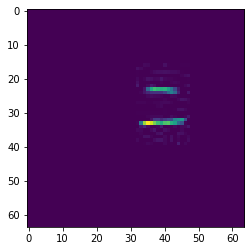

151 ,  0
JPEG
(64, 64)


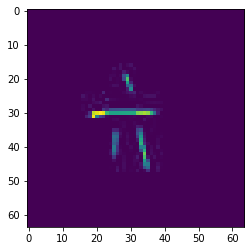

184 ,  1
JPEG
(64, 64)


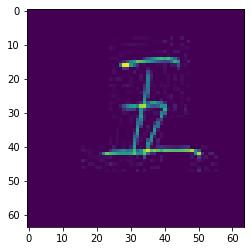

196 ,  2
JPEG
(64, 64)


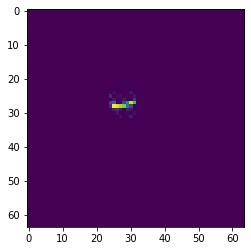

175 ,  3


In [3]:
%matplotlib inline

for i in range(0, 4):
    image = Image.open('../input/mnist-but-chinese/MNIST_Chinese_Hackathon/Training_Data/' 
                       + str(random.randint(1000*i, 1000*(i+2))))
    print(image.format)
    arr = np.array(image)
    print(arr.shape)
    plt.imshow(arr)
    plt.show()
    print(arr.max(), ', ', i)

This clearly shows that:
1. the image is `64x64` (from `print(arr.shape)`)
2. grayscale (from the fact that there's only one channel - nevermind what you see. `pyplot.plot` colormaps aren't the most reliable)
3. is a `JPEG` (self-evident from the o/p. Less evident from the beautiful `JPEG` artifacts, but evident nonetheless)

From the max pixel value, it is fairly certain the range of intensities will be `0-255`.

# Importing training labels

`train.csv` contains 2 columns: `id` - which gives the name of the image in the `Training_Data` folder, and `code` - which contains the true encodings of the character in the image (as written in the introduction).

`test.csv` will be used towards the end. It has only one column: `id`.

In [4]:
train = pd.read_csv('../input/mnist-but-chinese/MNIST_Chinese_Hackathon/train.csv')
test = pd.read_csv('../input/mnist-but-chinese/MNIST_Chinese_Hackathon/test.csv')

In [5]:
train.code.value_counts()

15    667
14    667
13    667
12    667
4     667
11    667
3     667
10    667
2     667
1     667
7     666
6     666
5     666
9     666
8     666
Name: code, dtype: int64

So the training set is pretty uniform, thankfully. No further preprocessing is required on this at least. Scrumptious.

Also a good thing because the training will be done pretty uniformly, which is good news for the model's generalisability.

# Importing the raw image data (into Numpy)

And performing necessary preprocessing on it:

1. **putting it into a `NumPy` array**: to ease mathematical operations
2. **scaling**: brings the pixel values from `[0, 255]` to `[0, 1]`
3. **Mean-normalisation**: brings the pixel values from `[0, 1]` to `[-1, 1]`

In [6]:
X_train = []

for i in train.id:
    img = Image.open('../input/mnist-but-chinese/MNIST_Chinese_Hackathon/Training_Data/' + str(i))
    img_n = np.asarray(img)
    img_n = img_n/255
    img_n = (img_n - 0.5)/0.5
    X_train.append(img_n)    

y_train = train.code

`mean` and `std_dev` were taken as `0.5` and `0.5` - since the pixel values were scaled from `[0, 255]` to `[0, 1]`. I could go on and use the actual mean and standard deviation of the dataset, but this seems to work fine. I might try using that in the future and check what effect it has on the accuracy and loss landscape.

In [7]:
X_train = np.array(X_train)
X_train = X_train.astype(np.float32)

y_train = np.array(y_train)
y_train = y_train.astype(np.float32)
y_train = y_train - 1 # to make the labels go from 0-14, to be consistent with Python's indexing convention for the softmax fn

print('Train set dims = ', (X_train.shape))

Train set dims =  (10000, 64, 64)


These shapes confirm that the array is 64x64 in shape, with the training set having 10k samples.

Now for a final look at the `X_train` array, to verify whether I've loaded the images correctly:

(<matplotlib.axes._subplots.AxesSubplot at 0x7f33ca8e0e10>,
 <matplotlib.image.AxesImage at 0x7f33ca925290>)

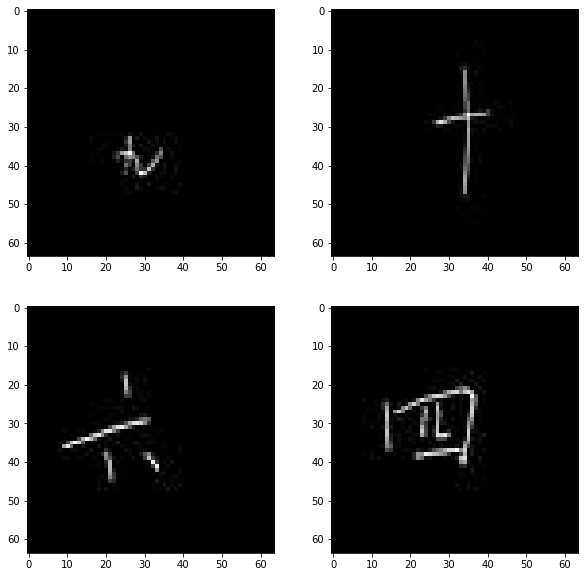

In [8]:
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1), plt.imshow(X_train[random.randint(1, 2500)], cmap='gray')
plt.subplot(2, 2, 2), plt.imshow(X_train[random.randint(2501, 5000)], cmap='gray')
plt.subplot(2, 2, 3), plt.imshow(X_train[random.randint(5001, 7500)], cmap='gray')
plt.subplot(2, 2, 4), plt.imshow(X_train[random.randint(7501, 10000)], cmap='gray')

In [9]:
X_train.shape

(10000, 64, 64)

In [10]:
from torch import nn
from torch import optim

# Implementing a (very) modified `LeNet-5` architecture

1. `3x3` conv, stride = `1` (`6` filters)
2. `3x3` conv, stride = `1` (`6` filters)
3. Max pooling, f = `2`, s = `2`
4. `3x3` conv, stride = `1` (`16` filters)
5. Max pooling, f = `2`, s = `2`
6. FCL (`500` units)
7. FCL (`90` units)
8. Output layer (`15` units) 

# Differences from the original `LeNet-5` paper:

**1.** instead of average pooling, **max pooling** is used

**2.** instead of `sigmoid` and `tanh` non-linearities, **`ReLU`** is used

**3.** The number of units in each FCL is decided as per the 64x64 **size of the image data**, and also on the **nature of the characters used** in the Chinese language. The following were the justifications made in the original paper:


   * The original `LeNet-5` paper specified that the first "full-connected layer" with `120` units <u>was in fact a convolution layer</u>, but since the kernel size matched the input size for that layer, it <u>functioned as a full-connected layer</u>. Here, **I explicitly state it as a FCL**, and <u>made it to have 500 units to capture **the finer details of Chinese writing**</u>.
   * The choice of `84` units for the next FCL was based on the fact that <u>this model could be used to identify characters from a `7x12` bitmap</u> - not necessarily numerals but also "stylised characters", as they were called in the original paper.
 
**4.** the kernel size is now `3x3` - since Chinese is a language with fine and distinct strokes, <u>which might be blurred and thus, hidden if I use a larger kernel</u>.

**5.** the first `5x5` convolution is replaced by 2 consecutive `3x3` convolutions, to:

  * <u>increase non-linearities</u> in the network, since there is an extra layer now. This helps to make the model a tiny bit more robust.
  
  * decrease number of trainable parameters, which <u>reduces overfitting</u> in the model and <u>increases computational efficiency</u>.

In [11]:
class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()
        self.conv_layers = nn.Sequential(

            nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=0),
#             nn.LeakyReLU(0.01),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(6, 6, kernel_size=3, stride=1, padding=0),
#             nn.LeakyReLU(0.01),
            nn.ReLU(inplace = True),    
            nn.MaxPool2d(kernel_size=2, stride=2),
      
            nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=0),
#             nn.LeakyReLU(0.01),
            nn.ReLU(inplace = True),  
            nn.MaxPool2d(kernel_size=2, stride=2) 
      )

        self.FCL = nn.Sequential(
            nn.Linear(3136, 500),
#             nn.LeakyReLU(0.01),
            nn.ReLU(inplace = True),
            nn.Linear(500, 90),
#             nn.LeakyReLU(0.01),
            nn.ReLU(inplace = True),
            nn.Linear(90, 15)
#             nn.Softmax(dim = 1)
      )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.size(0), -1)
        x = self.FCL(x)
        return x

# Choice of optimiser and loss function

The ***optimiser*** used is `optim.Adam`, with a learning-rate of `0.001`, which is one of the better choices as per <a href = "https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2" target="_blank">this Medium article</a>. The Adam optimiser is generally deemed to converge faster than stochastic gradient descent, which is a major point in its favour.

The ***loss function*** used is `nn.CrossEntropyLoss` since this is a multi-class classification problem. Since it inherently includes a `softmax` operation, I didn't include a separate `softmax` layer in my network architecture earlier. It'll be included later on while making the predictions, along with `np.argmax`.

In [12]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FCL): Sequential(
    (0): Linear(in_features=3136, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=90, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=90, out_features=15, bias=True)
  )
)


Now to finally train the model on the entire training set:

In [13]:
X_train = X_train.reshape(10000, 1, 64, 64)
X_train  = torch.from_numpy(X_train)
y_train = y_train.astype(int)
y_train = torch.from_numpy(y_train)

# Training the model, setting no. of epochs

### *NOTE: the following cell WILL take a lot of time to execute, if you're using a CPU.*

*You may skip it if you wish, or use a GPU to speed up the training. I achieved an accuracy of about `93.5%` on <a href="https://www.kaggle.com/c/mnist-but-chinese/leaderboard" target="_blank">the competition leaderboard</a> at around `16-17` epochs, so you may stop there, or push forward to see the effect of a longer training duration on the model's generalisability.*

This cell will show the `CrossEntropy` losses after every epoch (i.e. a full pass of the entire training set of 10,000 samples) It can be modified suitably to show changes in loss when the model is in-between epochs, though this will necessitate changes to the plotting function too.

In [14]:
losses = []
runs = []

for epoch in range(15):
    running_loss = 0
    for i in range(len(X_train)):

        if torch.cuda.is_available():
            X_train[i] = X_train[i].cuda()
            y_train[i] = y_train[i].cuda()

        optimizer.zero_grad()
        X_train[i] = X_train[i].unsqueeze_(0)
        y_train[i] = y_train[i].unsqueeze_(0)
        output = model(X_train[i][None, ...].cuda()) 

        loss = criterion(output, y_train[[i]].long().cuda())     
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 10000 == 9999:
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss / 10000))
            losses.append(running_loss/10000)
            runs.append(epoch)
            running_loss = 0.0

[1, 10000] loss: 1.0905056
[2, 10000] loss: 0.2928257
[3, 10000] loss: 0.1474837
[4, 10000] loss: 0.0983169
[5, 10000] loss: 0.0810774
[6, 10000] loss: 0.0703672
[7, 10000] loss: 0.0641143
[8, 10000] loss: 0.0585473
[9, 10000] loss: 0.0522927
[10, 10000] loss: 0.0618995
[11, 10000] loss: 0.0578610
[12, 10000] loss: 0.0505022
[13, 10000] loss: 0.0567043
[14, 10000] loss: 0.0486654
[15, 10000] loss: 0.0558702


# Plotting the changes in loss over the epochs

Execute the following to plot the graph of loss against number of epochs - this depends on whichever point you chose to stop the execution of the previous cell. The model may be in-between epochs with its training, but it'll show the loss up until the last complete epoch only.

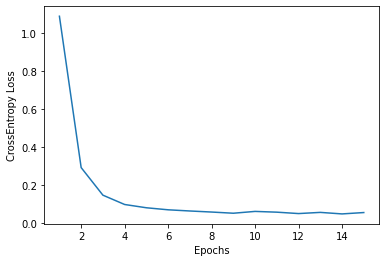

In [15]:
import copy

runs_mod = copy.deepcopy(runs)
for i in range(len(runs)):
    runs_mod[i] = runs[i] + 1

plt.plot(runs_mod, losses)
plt.xlabel("Epochs")
plt.ylabel("CrossEntropy Loss")
plt.show()

# Making predictions on test-set

The model is now trained (to whatever epoch you stopped the execution of the training cell at) and can now be used to make predictions on the test set. The weights and biases of the trained model may be checked by calling `model.state_dict()

Converting test dataset to `dtype=torch.Tensor`, and passing it through the model:

In [16]:
X_test = []

for i in test.id:
    img = Image.open('../input/mnist-but-chinese/MNIST_Chinese_Hackathon/Testing_Data/' + str(i))
    img_n = np.asarray(img)
    img_n = img_n/255
    img_n = (img_n - 0.5)/0.5
    X_test.append(img_n)

X_test = np.array(X_test)
X_test = X_test.astype(np.float32)
X_test = X_test.reshape(5000, 1, 64, 64)
X_test  = torch.from_numpy(X_test)

In [17]:
test_preds = model(X_test.cuda())

The above is the raw output from the model, for the test set. This needs to be passed into the `nn.functional.softmax` function, so that probabilities (that sum up to 1) are returned.

In [18]:
from torch.nn import functional as F

p = F.softmax(test_preds).data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


The following cell will convert the predictions into a CPU Tensor from a GPU/CUDA Tensor:

In [19]:
p = p.cpu()

Note the fact that the choice of dimension needs to be explicitly specified. I am saved from that headache (for now) by the Jupyter kernel. Good guy Jupyter!

The `softmax` probability outputs are now passed through the `argmax` function, which returns the index of the element with the highest probability. This is great for us, since our encodings for the numerals are from 1-15. 

**HOWEVER**, the `argmax` function's outputs begin from `0` (as is the convention with Python), so care needs to be taken to append the correct values. This can easily be achieved adding 1 to the output.

**ALSO**, since the input is a tensor, even though the `argmax` output is a single number, it will be of `dtype=<torch.Tensor>`. Since it doesn't make sense to append a `torch.Tensor` to a `DataFrame`, I'll need to pull the numeric value of the `argmax` output from the `torch.Tensor`. This is done by using the `.item()` method in `PyTorch`.

In [20]:
code = []

for i in range(len(p)):
    cache = np.argmax(p[i])
    code.append(cache.item() + 1)

***Sanity check*** - looking at the number of elements, and at the distribution of unique values.

In [21]:
print("The length of the set of predicted values is: ", len(code))
print("\nValue vs. Value Counts:")
print(pd.Series(code).value_counts())

The length of the set of predicted values is:  5000

Value vs. Value Counts:
3     431
15    394
7     363
5     349
6     347
1     338
13    337
11    322
8     320
2     319
14    314
9     313
10    300
12    300
4     253
dtype: int64


# Making the submission file

The `submission.csv` needs to be in the given format: one column for `id` (which is also the file-name of the image in `./Testing_Data`) and one column for `code`, which includes the encodings of the predicted labels (as per the given naming convention).

Viewing the first 10 entries of the `DataFrame`:

In [22]:
test['code'] = code
test.head(10)

,id,code
0,1,14
1,2,9
2,3,3
3,4,11
4,5,15
5,6,9
6,7,1
7,8,1
8,9,14
9,10,3


Checking the distribution of the predicted labels:

In [23]:
test.code.value_counts()

3     431
15    394
7     363
5     349
6     347
1     338
13    337
11    322
8     320
2     319
14    314
9     313
10    300
12    300
4     253
Name: code, dtype: int64

And finally, writing the `test` `DataFrame` to a `.csv`:

In [24]:
test.to_csv('./submission.csv', index = False)

Making this submission to the Kaggle competition, I got an accuracy score of `90.707%` on the private and `100%` on the public leaderboard. This is worse than my best submission of `93.535%` private/`92%` public. The reason for this could be that my best submission was trained for `16-17` epochs (intermediate stoppage), while the one on Kaggle (i.e. this notebook) was trained for `15` complete epochs.

This is also dependent on the weight initialisation - we used <a href = "https://arxiv.org/pdf/1502.01852v1.pdf" target = "_blank">the default initialiser</a>.

# Fin!

Please consider checking out <a href = "https://www.linkedin.com/in/utkarshc99/" target = "_blank">my LinkedIn profile</a>! I'll be glad to receive any feedback on this notebook, or even just to connect.

Please drop an upvote or a comment if you appreciate this submission!